# Digit Recognizer
Learn Computer Vision Fundamentals

## Data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

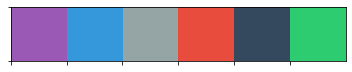

In [1]:
# Toolbox
import pandas as pd
import numpy as np
import random
import sys
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import norm

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

In [2]:
import tensorflow as tf
import tensorflow.keras
import keras

print('These are the current versions working for me as of 2019-08-04')
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print(f"Keras GPU: {keras.backend.tensorflow_backend._get_available_gpus()}")
print()
print(f"TF Session: {tf.Session()}")
print()
print(f"Python {sys.version}")

Using TensorFlow backend.


These are the current versions working for me as of 2019-08-04
TensorFlow Version: 1.13.1
TensorFlow Keras Version: 2.2.4-tf
Keras Version: 2.2.4

TensorFlow-GPU is available
TensorFlow CUDA: True
Tensorflow GPU Device Currently Activated: /device:GPU:0
Keras GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']

TF Session: <tensorflow.python.client.session.Session object at 0x0000024144EE3320>

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


### Define functions

In [3]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

### Load data

In [4]:
# Load data
train_file  = 'LargeData/train.csv'
test_file = 'LargeData/test.csv'
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

In [5]:
# Split label
train_label = train.label
train = train.drop('label', axis=1)

### Preprocessing

In [6]:
# Training size
training_size = train_label.shape[0]

In [7]:
# Update data as float32
train_array = train.values.astype('float32')
train_label_array = train_label.astype('int32')
test_array = test.values.astype('float32')

In [8]:
# Normalize the data since its on RGB scale then divide by 255
train_array = train_array / 255.0
test_array = test_array / 255.0

In [9]:
# Reshape the data so it would fit input size in the model (np.expand_dims(img, axis=0))
train_array_reshape = train_array.reshape(train_array.shape[0], 28, 28, 1) # (42000, 28, 28, 1) grayscale
test_array_reshape = test_array.reshape(test_array.shape[0], 28, 28, 1)

In [10]:
# Split the data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(train_array_reshape, train_label_array, test_size=0.20, random_state=100)

### Exploration

In [11]:
print('Training Size = {}'.format(X_train.shape[0]))
print('Validation Size = {}'.format(X_validation.shape[0]))
print('Unique Classes = {}'.format(len(np.unique(y_train))))

Training Size = 33600
Validation Size = 8400
Unique Classes = 10


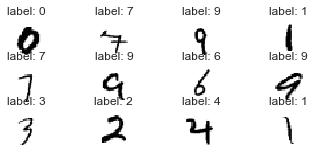

In [12]:
# Get image and label
image_and_label = list(zip(X_train, y_train))

# Show images
for index, (image, label) in enumerate(image_and_label[:12]):
    plt.subplot(5, 4, index+1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest') # Remove 1D entries from the shape
    plt.title('label: %i' % label) 

### Model

- __filters__: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)

- __kernel_size__: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions

- __strides__: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1

- __padding__: one of "valid" or "same"

- __activation__: Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x)

In [13]:
# Define the model
model = tf.keras.models.Sequential([
    
    # First convolutional layer (input)
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    # Second convolutional layer
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(rate=0.20),
    
    # Third convolutional layer
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(rate=0.20),
    
    # Flatten before dense layers
    tf.keras.layers.Flatten(),
    
    # First dense layer
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.20),
    
    # Output layer
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # categorical_crossentropy

Adam: A Method for Stochastic Optimization

https://arxiv.org/abs/1412.6980v8

In [15]:
# Callback function if model is not learning
callback_lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                                          patience=3,
                                                          verbose=1,
                                                          factor=0.5,
                                                          min_lr=0.00001
                                                          )

https://keras.io/callbacks/

In [16]:
# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In [17]:
# Define model parameters
EPOCHS = 30
BATCH_SIZE = 64
IMAGE_SHAPE = 28

### Data augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image augmentation
image_datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=False,
        vertical_flip=False,
        validation_split=0.2)

Class ImageDataGenerator

Generate batches of tensor image data with real-time data augmentation

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [19]:
# Fit training data
image_datagen.fit(X_train)

In [20]:
train_generator = image_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training')
validation_generator = image_datagen.flow(X_validation, y_validation, batch_size=BATCH_SIZE, subset='validation')

In [21]:
# Train the model
cnn_model = model.fit_generator(generator=train_generator,
                                validation_data=validation_generator,
#                                 validation_data=(X_validation, y_validation),
                                epochs=EPOCHS,
                                steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                                callbacks=[callback_lr_reduction]
                               )

Epoch 1/30
420/420 [==============================] - 6s 14ms/step - loss: 0.7477 - acc: 0.7471 - val_loss: 0.1854 - val_acc: 0.9405
Epoch 2/30
420/420 [==============================] - 5s 11ms/step - loss: 0.2033 - acc: 0.9396 - val_loss: 0.1178 - val_acc: 0.9679
Epoch 3/30
420/420 [==============================] - 5s 11ms/step - loss: 0.1410 - acc: 0.9576 - val_loss: 0.1023 - val_acc: 0.9696
Epoch 4/30
420/420 [==============================] - 5s 11ms/step - loss: 0.1165 - acc: 0.9665 - val_loss: 0.0753 - val_acc: 0.9762
Epoch 5/30
420/420 [==============================] - 5s 12ms/step - loss: 0.0987 - acc: 0.9711 - val_loss: 0.0648 - val_acc: 0.9810
Epoch 6/30
420/420 [==============================] - 4s 11ms/step - loss: 0.0821 - acc: 0.9772 - val_loss: 0.0583 - val_acc: 0.9821
Epoch 7/30
420/420 [==============================] - 5s 12ms/step - loss: 0.0795 - acc: 0.9768 - val_loss: 0.0570 - val_acc: 0.9792
Epoch 8/30
420/420 [==============================] - 4s 11ms/step - 

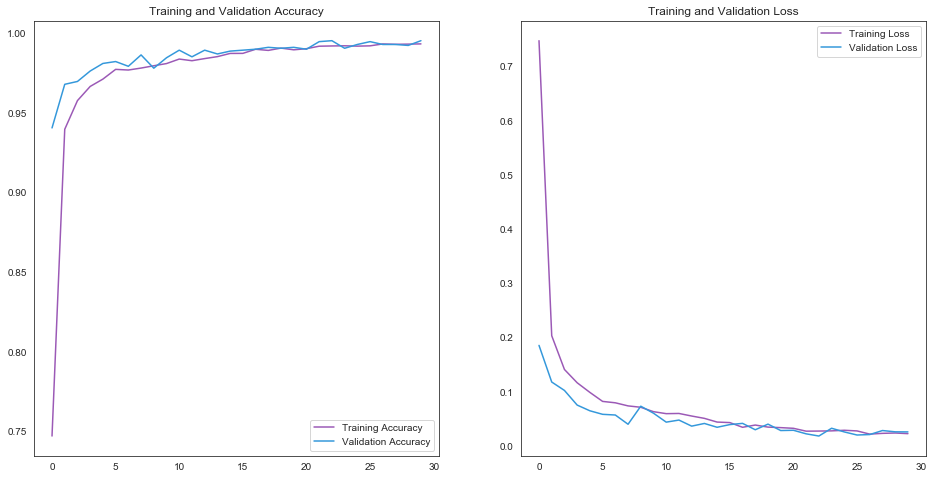

In [22]:
# Plot results
acc = cnn_model.history['acc']
val_acc = cnn_model.history['val_acc']
loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']
epochs_range = range(EPOCHS)

# Set figure space
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)

# Plot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Set plot features
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

# Set figure space
plt.subplot(1,2,2)

# Plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Set plot features
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.savefig('./training-data.png')
plt.show()

In [23]:
# Prediction
results = model.predict(test_array_reshape)
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

# Submission
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submission.to_csv('submissions.csv',index=False)

In [24]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [25]:
scores = model.evaluate(X_validation, y_validation, verbose=10)
print(scores)

[0.02489170441040707, 0.9941667]
